# Assignment 4, Structural optimization
### Author: Donglai Yang
### Date: Nov 16, 2025



In [41]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import minimize

class Truss:
    def __init__(self, conn, x, bcs, f, E=10.0, rho=0.1):
        self.conn = np.array(conn, dtype=int)
        self.x = np.array(x)
        self.bcs = np.array(bcs, dtype=int)
        self.f = np.array(f)
        self.E = E
        self.rho = rho

        # Extract the number of nodes and elements
        self.nnodes = self.x.shape[0]
        self.nelems = self.conn.shape[0]
        self.nvars = 2*self.nnodes

        # Form the reduced set of degrees of freedom
        self.reduced = np.setdiff1d(np.arange(2*self.nnodes), self.bcs)

        # Set up the i-j indices for the matrix - these are the row
        # and column indices in the stiffness matrix
        self.elem_vars = np.array((2*self.conn[:,0],
                                   2*self.conn[:,0]+1,
                                   2*self.conn[:,1],
                                   2*self.conn[:,1]+1)).T
        i = []
        j = []
        for index in range(self.nelems):
            for ii in self.elem_vars[index, :]:
                for jj in self.elem_vars[index, :]:
                    i.append(ii)
                    j.append(jj)

        # Convert the lists into numpy arrays
        self.i = np.array(i, dtype=int)
        self.j = np.array(j, dtype=int)

        return
    
    def compute_mass(self, A):
        """
        Compute the mass of the truss
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)

        mass = self.rho*np.sum(A*Le)

        return mass

    def assemble_stiffness_matrix(self, A):
        """
        Assemble the stiffness matrix
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        scale = self.E*A*Le

        # Compute all of the element matrices
        Ke = np.zeros((self.nelems, 4, 4), dtype=A.dtype)
        for i in range(self.nelems):
            Ke[i,:] = scale[i]*np.outer(B[i,:], B[i,:])

        K = sparse.coo_matrix((Ke.flatten(), (self.i, self.j)))
        K = K.tocsr()

        return K

    def compute_stiffness_matrix_derivative(self, y, z=None, alpha=1.0):
        """
        Compute the result:

        product = alpha * d(y^{T}*K(x)*z)/dx

        If z is None then the code uses y = z.
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        scale = self.E*Le

        if z is None:
            y_e = y[self.elem_vars]
            strain_y = np.sum(B*y_e, axis=1)

            product = alpha*scale*strain_y**2
        else:
            y_e = y[self.elem_vars]
            strain_y = np.sum(B*y_e, axis=1)

            z_e = z[self.elem_vars]
            strain_z = np.sum(B*z_e, axis=1)

            product = alpha*scale*strain_y*strain_z

        return product

    def assemble_mass_matrix(self, A):
        """
        Assemble the mass matrix
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        scale = 0.5*self.rho*A*Le

        N = np.zeros((self.nelems, 4))
        pt = 1.0/np.sqrt(3.0)
        u = 0.5 - 0.5*pt
        N[:, 0] = C*(1.0 - u)
        N[:, 1] = S*(1.0 - u)
        N[:, 2] = C*u
        N[:, 3] = S*u

        Me = np.zeros((self.nelems, 4, 4), dtype=A.dtype)
        for i in range(self.nelems):
            Me[i,:] += scale[i]*np.outer(N[i,:], N[i,:])

        u = 0.5 + 0.5*pt
        N[:, 0] = C*(1.0 - u)
        N[:, 1] = S*(1.0 - u)
        N[:, 2] = C*u
        N[:, 3] = S*u

        for i in range(self.nelems):
            Me[i,:] += scale[i]*np.outer(N[i,:], N[i,:])

        M = sparse.coo_matrix((Me.flatten(), (self.i, self.j)))
        M = M.tocsr()

        return M

    def compute_mass_matrix_derivative(self, y, z=None, alpha=1.0):
        """
        Compute the result:

        product = alpha * d(y^{T}*M(x)*z)/dx

        If z is None then the code uses y = z.
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le


        scale = 0.5*self.rho*Le

        N = np.zeros((self.nelems, 4))
        pt = 1.0/np.sqrt(3.0)
        u = 0.5 - 0.5*pt
        N[:, 0] = C*(1.0 - u)
        N[:, 1] = S*(1.0 - u)
        N[:, 2] = C*u
        N[:, 3] = S*u

        if z is None:
            y_e = y[self.elem_vars]
            Ny = np.sum(N*y_e, axis=1)

            product = alpha*scale*Ny**2
        else:
            y_e = y[self.elem_vars]
            Ny = np.sum(N*y_e, axis=1)

            z_e = z[self.elem_vars]
            Nz = np.sum(N*z_e, axis=1)

            product = alpha*scale*Ny*Nz

        u = 0.5 + 0.5*pt
        N[:, 0] = C*(1.0 - u)
        N[:, 1] = S*(1.0 - u)
        N[:, 2] = C*u
        N[:, 3] = S*u

        if z is None:
            y_e = y[self.elem_vars]
            Ny = np.sum(N*y_e, axis=1)

            product += alpha*scale*Ny**2
        else:
            y_e = y[self.elem_vars]
            Ny = np.sum(N*y_e, axis=1)

            z_e = z[self.elem_vars]
            Nz = np.sum(N*z_e, axis=1)

            product += alpha*scale*Ny*Nz

        return product
    
    def compute_stresses(self, u):
        """
        Compute the stresses in each element
        """

        # Compute the x and y distances between nodes
        xd = self.x[self.conn[:,1],0] - self.x[self.conn[:,0],0]
        yd = self.x[self.conn[:,1],1] - self.x[self.conn[:,0],1]
        Le = np.sqrt(xd**2 + yd**2)
        C = xd/Le
        S = yd/Le

        # Compute the B matrix
        B = np.zeros((self.nelems, 4))
        B[:, 0] = -C/Le
        B[:, 1] = -S/Le
        B[:, 2] = C/Le
        B[:, 3] = S/Le

        ue = np.array((u[2*self.conn[:,0]],
                       u[2*self.conn[:,0]+1],
                       u[2*self.conn[:,1]],
                       u[2*self.conn[:,1]+1]), dtype=u.dtype).T

        stress = self.E*np.sum(B*ue, axis=1)
        return stress

    def compliance(self, A):
        """
        Given the cross-sectional areas, compute the compliance
        """

        u = self.solve(A)
        return np.dot(u, self.f)

    def compliance_gradient(self, A):
        """
        Given the cross-sectional areas, compute the compliance gradient
        """

        u = self.solve(A)
        return self.compute_stiffness_matrix_derivative(u, alpha=-1.0)

    def frequencies(self, A, k=5, sigma=0.0):
        """
        Compute the k-th smallest natural frequencies
        """

        K = self.assemble_stiffness_matrix(A)
        Kr = self.reduce_matrix(K)

        M = self.assemble_mass_matrix(A)
        Mr = self.reduce_matrix(M)

        # Find the eigenvalues closest to zero. This uses a shift and
        # invert strategy around sigma = 0, which means that the largest
        # magnitude values are closest to zero.
        if k < len(self.reduced):
            eigs, phir = sparse.linalg.eigsh(Kr, M=Mr, k=k, sigma=sigma,
                                             which='LM', tol=1e-6)
        else:
            eigs, phir = scipy.linalg.eigh(Kr.todense(), b=Mr.todense())
            k = len(eigs)

        phi = np.zeros((self.nvars, k))
        for i in range(k):
            phi[self.reduced, i] = phir[:, i]

        return np.sqrt(eigs), phi

    def frequency_derivative(self, A, k=5):
        """
        Compute the gradient of the smallest eigenvalues, assuming they are unique
        """
        if k > len(self.reduced):
            k = len(self.reduced)

        omega, phi = self.frequencies(A, k=k)

        omega_grad = []
        for i in range(k):
            kx = self.compute_stiffness_matrix_derivative(phi[:, i])
            mx = self.compute_mass_matrix_derivative(phi[:, i])
            grad = kx - mx*omega[i]**2
            omega_grad.append((0.5/omega[i])*grad)

        return omega_grad

    def ks_min_eigenvalue(self, A, ks_rho=100.0, k=5):
        """
        Compute the ks minimum eigenvalue
        """
        if k > len(self.reduced):
            k = len(self.reduced)

        omega, phi = self.frequencies(A, k=k)
        lamb = omega**2

        c = np.min(lamb)
        eta = np.exp(-ks_rho*(lamb - c))
        a = np.sum(eta)
        ks_min = c - np.log(a)/ks_rho
        eta *= 1.0/a

        ks_grad = np.zeros(self.nelems)
        for i in range(k):
            kx = self.compute_stiffness_matrix_derivative(phi[:, i])
            mx = self.compute_mass_matrix_derivative(phi[:, i])
            ks_grad += eta[i]*(kx - mx*lamb[i])

        return ks_min, ks_grad

    def eigenvector_derivative(self, A, k=5, i=0):

        if k > len(self.reduced):
            k = len(self.reduced)

        omega, phi = self.frequencies(A, k=k)
        lamb = omega**2

        mx = self.compute_mass_matrix_derivative(phi[:, i])
        grad = -0.5*np.outer(phi[:, i], mx)

        for j in range(k):
            if j != i:
                kx = self.compute_stiffness_matrix_derivative(phi[:, i], phi[:, j])
                mx = self.compute_mass_matrix_derivative(phi[:, i], phi[:, j])
                gx = (kx - lamb[i]*mx)/(lamb[i] - lamb[j])
                grad += np.outer(phi[:, j], gx)

        return grad

    def reduce_vector(self, forces):
        """
        Eliminate essential boundary conditions from the vector
        """
        return forces[self.reduced]

    def reduce_matrix(self, matrix):
        """
        Eliminate essential boundary conditions from the matrix
        """
        temp = matrix[self.reduced, :]
        return temp[:, self.reduced]

    def solve(self, A, f=None):
        """
        Perform a linear static analysis
        """

        K = self.assemble_stiffness_matrix(A)
        Kr = self.reduce_matrix(K)
        if f is None:
            f = self.f
        fr = self.reduce_vector(f)

        ur = sparse.linalg.spsolve(Kr, fr)

        u = np.zeros(2*self.nnodes, dtype=ur.dtype)
        u[self.reduced] = ur

        return u

    def plot(self, u=None, scale=1.0, **kwargs):
        """
        Visualize the truss and optionally its deformation.
        """
        fig, ax = plt.subplots(1, 1, facecolor='w', **kwargs)

        if u is not None:
            x = self.x + scale*u.reshape((-1, 2))
        else:
            x = self.x

        for index in range(self.nelems):
            i = self.conn[index, 0]
            j = self.conn[index, 1]
            plt.plot([x[i,0], x[j,0]], [x[i,1], x[j,1]], '-ko')

        ax.axis('equal')

        return

    def plot_areas(self, A, **kwargs):
        """
        Plot the bar areas
        """
        fig, ax = plt.subplots(1, 1, facecolor='w', **kwargs)

        stress = self.compute_stresses(self.solve(A))

        cm = plt.get_cmap('coolwarm')
        cNorm = colors.Normalize(vmin=min(stress), vmax=max(stress))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

        for index, bar in enumerate(self.conn):
            n1 = bar[0]
            n2 = bar[1]
            if A[index] >= 1e-4*max(A):
                plt.plot([self.x[n1, 0], self.x[n2, 0]],
                         [self.x[n1, 1], self.x[n2, 1]],
                         color=scalarMap.to_rgba(stress[index]),
                         linewidth=5*(A[index]/max(A)))

        ax.axis('equal')

        return

In [25]:
def finite_difference_real_grad(x_vec, func, h=1e-8):
    # compute the finite difference gradient for a function at x_vec
    # where x_vec can be any length
    dfdx = np.zeros(len(x_vec))
    for i in range(len(x_vec)):
        x_plus_h = np.array(x_vec, dtype=float)
        x_plus_h[i] += h
        f_plus_h = func(x_plus_h)
        f0 = func(x_vec)
        dfdx[i] = (f_plus_h - f0)/h
    return dfdx
            
def finite_difference_complex_grad(x_vec, func, h=1e-8): 
    dfdx = np.zeros(len(x_vec))
    for i in range(len(x_vec)):
        x_plus_ih = np.array(x_vec, dtype=complex)
        x_plus_ih[i] += 1j*h
        f_plus_ih = func(x_plus_ih)
        dfdx[i] = np.imag(f_plus_ih)/h
    return dfdx

# Part 1
Implement the natural frequency analysis problem for a truss. Find the derivative of the natural frequencies with respect to bar areas. Verify these derivatives using finite-difference methods

#### Answer:
Here I make use the code in the lecture notes. The code below verifies the analytical gradient with respect to the finite difference based gradient. The plot below shows that while finite difference method (Real valued) produces good error analysis curve and verifies the analytical implementation, the complex-step method does not work. This make sense since the computation of eigenvalue using scipy does not work well with matrix with complex values, and thus we are getting nonsense.

In [42]:
E = 70e9 # 70 GPa, Young's modulus
sigma_max = 300e6 # max stress in Pa
rho = 2700 # kg/m^3, density
Amin = 1e-3 # minimum area in m^2
L = 2.5 # m, length

xpos = [[0,0],[0,L],[L,L],[L,0],[2*L,0],[2*L,L],[3*L,L],[3*L,0], [4*L,0],[4*L,L],[5*L,L],[5*L,0]]
conn = [[0,1],[1,2],[1,3],[0,2],[0,3],[2,3],[2,5],[2,4],[3,5],[3,4],[4,5],[5,6],[5,7],[4,6],[4,7],[7,6],[6,9],[6,8],[7,9],[7,8],[8,9],[9,10],[9,11],[8,10],[8,11],[10,11]]
bcs = [0,1,22,23]
force = [0,0,0,0,
         0,0,0,0,
         0,0,0,0,
         0,0,0,0,
         0,0,0,0,
         0,0,0,0] # frequency analysis, so no external forces is prescribed explicitly


prob = Truss(conn, xpos, bcs, force, E=E, rho=rho)

Frequency:  [  18.65613208   -8.67343783   -4.4770848   177.7637428    39.99600388
  -84.06150757  273.22472966 -150.68158952  -43.29559333    7.45006709
 -258.48354608  445.97945687 -214.47787582 -214.47787582   48.140462
 -258.48354608  273.22472966  -43.29559333 -150.68158952    7.45006709
  -84.06150757   -8.67343783  177.7637428    -4.4770848    39.99600388
   18.65613208]


/tmp/ipykernel_1782158/2602065750.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dfdx[i] = (f_plus_h - f0)/h
/tmp/ipykernel_1782158/2913091485.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  phi[self.reduced, i] = phir[:, i]
/tmp/ipykernel_1782158/2602065750.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dfdx[i] = np.imag(f_plus_ih)/h


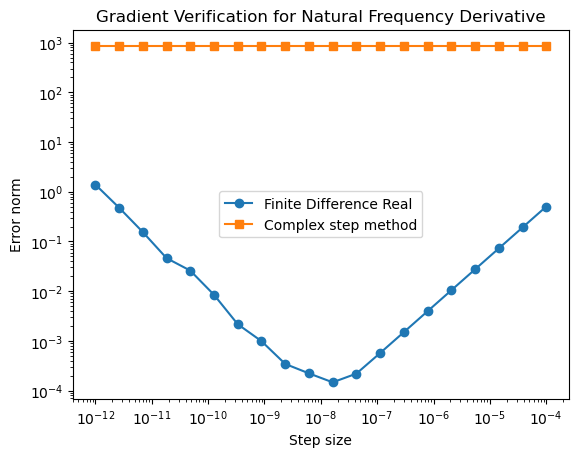

In [27]:
 # initial area where derivative is evaluated
A = np.ones(prob.nelems)*0.1

# only look at the smallest eigenvalue (frequency)
omega_grad_analytical = prob.frequency_derivative(A, k=1)
print("Frequency: ", omega_grad_analytical[0])

# compute the finite difference based gradient
# here we use both real and complex step methods for verification
step_sizes = np.logspace(-12, -4, num=20)
fd_real_errors = []
fd_comp_errors = []

for step in step_sizes:
    fd_real = finite_difference_real_grad(A, lambda x: prob.frequencies(x, k=1)[0], h=step)
    fd_comp = finite_difference_complex_grad(A, lambda x: prob.frequencies(x, k=1)[0], h=step)
    # append
    fd_real_errors.append(np.linalg.norm(omega_grad_analytical[0] - fd_real))
    fd_comp_errors.append(np.linalg.norm(omega_grad_analytical[0] - fd_comp))

# plot the errors
plt.loglog(step_sizes, fd_real_errors, 'o-', label='Finite Difference Real')
plt.loglog(step_sizes, fd_comp_errors, 's-', label='Complex step method')
plt.xlabel('Step size')
plt.ylabel('Error norm')
plt.legend()
plt.title('Gradient Verification for Natural Frequency Derivative')
plt.show()

# Part 2
Implement a KS function that approximates the minimum natural frequency of a truss. Verify the derivatives of the KS function with respect to the design variables

#### Answer:
I took the KS function and its derivative implementation from the lecture notes. The plot below shows that the analytical gradient is indeed verified.

KS Minimum Eigenvalue:  148372.4287269864
KS Gradient Analytical:  [  14372.36395085   -6681.86763867   -3449.06928695  136946.13641775
   30812.23492326  -64759.54264681  210487.64226158 -116082.51035279
  -33354.18200371    5739.40382021 -199131.28744339  343574.91904663
 -165230.07435915 -165230.07435915   37086.58566898 -199131.28744339
  210487.64226158  -33354.1820037  -116082.51035279    5739.40382021
  -64759.54264681   -6681.86763867  136946.13641775   -3449.06928695
   30812.23492326   14372.36395085]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


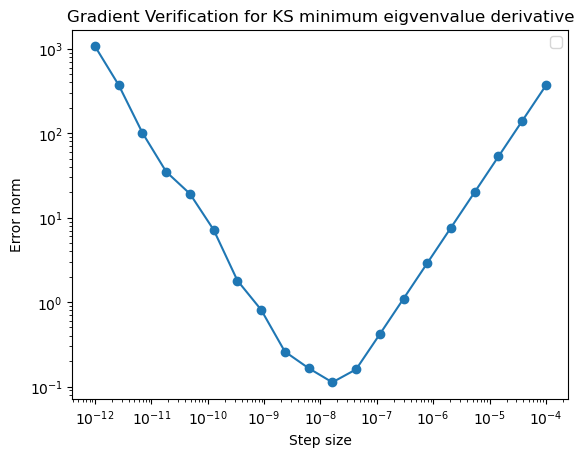

In [33]:
 # initial area where derivative is evaluated
A = np.ones(prob.nelems)*0.1

ks_min, ks_grad_analytical = prob.ks_min_eigenvalue(A, ks_rho=100.0, k=5)
print("KS Minimum Eigenvalue: ", ks_min)
print("KS Gradient Analytical: ", ks_grad_analytical)


# compute the finite difference based gradient
# here we use only the real-valued finite difference method for verification
step_sizes = np.logspace(-12, -4, num=20)
fd_real_errors = []

for step in step_sizes:
    fd_real = finite_difference_real_grad(A, lambda x: prob.ks_min_eigenvalue(x, ks_rho=100.0, k=5)[0], h=step)
    # append
    fd_real_errors.append(np.linalg.norm(ks_grad_analytical - fd_real))

# plot the errors
plt.loglog(step_sizes, fd_real_errors, 'o-')
plt.xlabel('Step size')
plt.ylabel('Error norm')
plt.legend()
plt.title('Gradient Verification for KS minimum eigvenvalue derivative')
plt.show()

# Part 3:
Maximize the minimum natural frequency of a truss subject to a mass constraint. Approximate the minimum natural frequency using a KS function

#### Answer:
I don't see an explicit mass constraint, but in the problem it specifies the minimum area, and so I assume that we need to compute the minimum mass constraint from it. The optimization output can be seen below, along with a plot of the optimized structure.

Minimum mass with all areas at Amin: 203.45941546018395
Optimization terminated successfully    (Exit mode 0)
            Current function value: -572885.9633839849
            Iterations: 10
            Function evaluations: 30
            Gradient evaluations: 6
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -572885.9633839849
       x: [ 1.995e+00  4.871e-01 ...  1.993e+00  1.995e+00]
     nit: 10
     jac: [-8.976e+02  2.405e+02 ... -1.615e+03 -8.998e+02]
    nfev: 30
    njev: 6
Mass is: 215063.51069159753  and the minimum mass is : 203.45941546018395
The minimum natural frequency is : 572885.9633839849


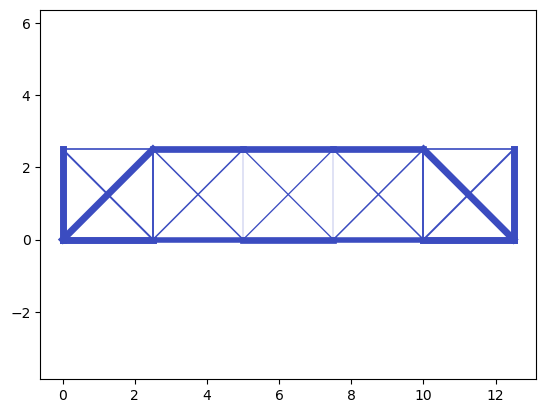

In [67]:
# Compute the gradient of the mass of the truss
xd = prob.x[prob.conn[:,1],0] - prob.x[prob.conn[:,0],0]
yd = prob.x[prob.conn[:,1],1] - prob.x[prob.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = rho*Le

options = {
    'maxiter': 100,  # Limit to 100 iterations
    'disp': True    # Display convergence messages
}

# minimum bar size
Amin = 1e-3
m_min = prob.compute_mass(np.ones(prob.nelems)*Amin)
print("Minimum mass with all areas at Amin:", m_min)

# optimization
# maximize the minimum natural frequency (using KS) subject to a mass constraint
np.random.seed(42)
x0 = np.ones(prob.nelems)*0.1
res = minimize(lambda x: -1*prob.ks_min_eigenvalue(x)[0], x0, 
               jac=lambda x: -1*prob.ks_min_eigenvalue(x)[1],
               method='SLSQP',
               bounds=[(1e-12, 10.0)]*len(x0),
               constraints=[{'type': 'ineq',
                             'fun': lambda x: prob.compute_mass(x) - m_min,
                             'jac': lambda x: np.array(m0)}],
                             options=options)

# Show the bar areas
print(res)

print("Mass is:", prob.compute_mass(res.x), " and the minimum mass is :", m_min)
print("The minimum natural frequency is :", prob.ks_min_eigenvalue(res.x)[0])
prob.plot_areas(res.x)


# Part 4
How does your design compare to a compliance minimization result? Explain similarities / differences in the design you observe?

#### Answer:
The problem didn't specify the loading. I am therefore I assuming that we are comparing our frequency-based design to the problem 2 in Assignment 2. In that case, I am assuming a load P that is identical to that problem and solve the compliance optimization problem. From the optimization output, we can see that the frequency-based optimization produces thicker bars at the base and on the sides of the anchor points, while the compliance-based optimization produces thicker bars along the "dome" shape structure. The frequency-based optimization indeed produces higher minimum frequency as compared to that from the complianced-based optimization.

Minimum mass with all areas at Amin: 203.45941546018395
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00032425193292026243
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.00032425193292026243
       x: [ 1.080e+00  1.080e+00 ...  2.125e+00  1.080e+00]
     nit: 16
     jac: [-2.205e-06 -2.205e-06 ... -3.871e-06 -2.205e-06]
    nfev: 16
    njev: 16
Mass is: 564323.4670131378  and the minimum mass is : 203.45941546018395
The minimum natural frequency is : 107279.12065886114


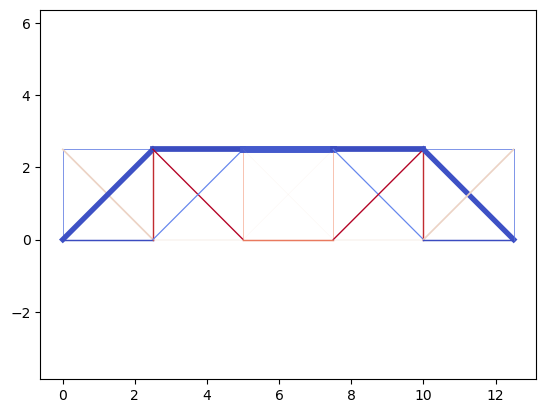

In [69]:
P = 1000.0 # N
force_compliance = [0,0,0,0,
                    0,0,-P/4,-P,
                    0,-P,0,0,
                    0,0,0,-P,
                    P/4,-P,0,0,
                    0,0,0,0]

prob_c = Truss(conn, xpos, bcs, force_compliance, E=E, rho=rho)

# Compute the gradient of the mass of the truss
xd = prob_c.x[prob_c.conn[:,1],0] - prob_c.x[prob_c.conn[:,0],0]
yd = prob_c.x[prob_c.conn[:,1],1] - prob_c.x[prob_c.conn[:,0],1]
Le = np.sqrt(xd**2 + yd**2)
m0 = rho*Le

options = {
    'maxiter': 100,  # Limit to 100 iterations
    'disp': True    # Display convergence messages
}

# minimum bar size
Amin = 1e-3
m_min = prob_c.compute_mass(np.ones(prob_c.nelems)*Amin)
print("Minimum mass with all areas at Amin:", m_min)

# optimization
# maximize the minimum natural frequency (using KS) subject to a mass constraint
x0 = np.ones(prob_c.nelems)*0.1
res = minimize(prob_c.compliance, x0, 
               jac=lambda x: prob_c.compliance_gradient(x),
               method='SLSQP',
               bounds=[(1e-12, 10.0)]*len(x0),
               constraints=[{'type': 'ineq',
                             'fun': lambda x: prob_c.compute_mass(x) - m_min,
                             'jac': lambda x: np.array(m0)}],
                             options=options)

# Show the bar areas
print(res)

print("Mass is:", prob_c.compute_mass(res.x), " and the minimum mass is :", m_min)
print("The minimum natural frequency is :", prob_c.ks_min_eigenvalue(res.x)[0])
prob_c.plot_areas(res.x)